# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

In [2]:
# import numpy
import numpy as np

# number of training examples
n_train = len(X_train)

#number of validation examples
n_valid = len(X_valid)

# number of testing examples
n_test = len(X_test)

# shape of a traffic sign image
image_shape = X_train[0].shape

# number of unique classes/labels in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

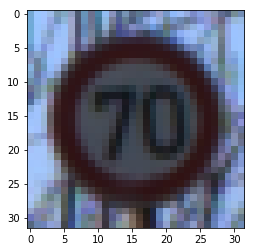

In [4]:
# Show a sample traffic sign image chosen randomly from training data
rand_n = np.random.randint(0, n_train)
plt.imshow(X_train[rand_n])
plt.show()

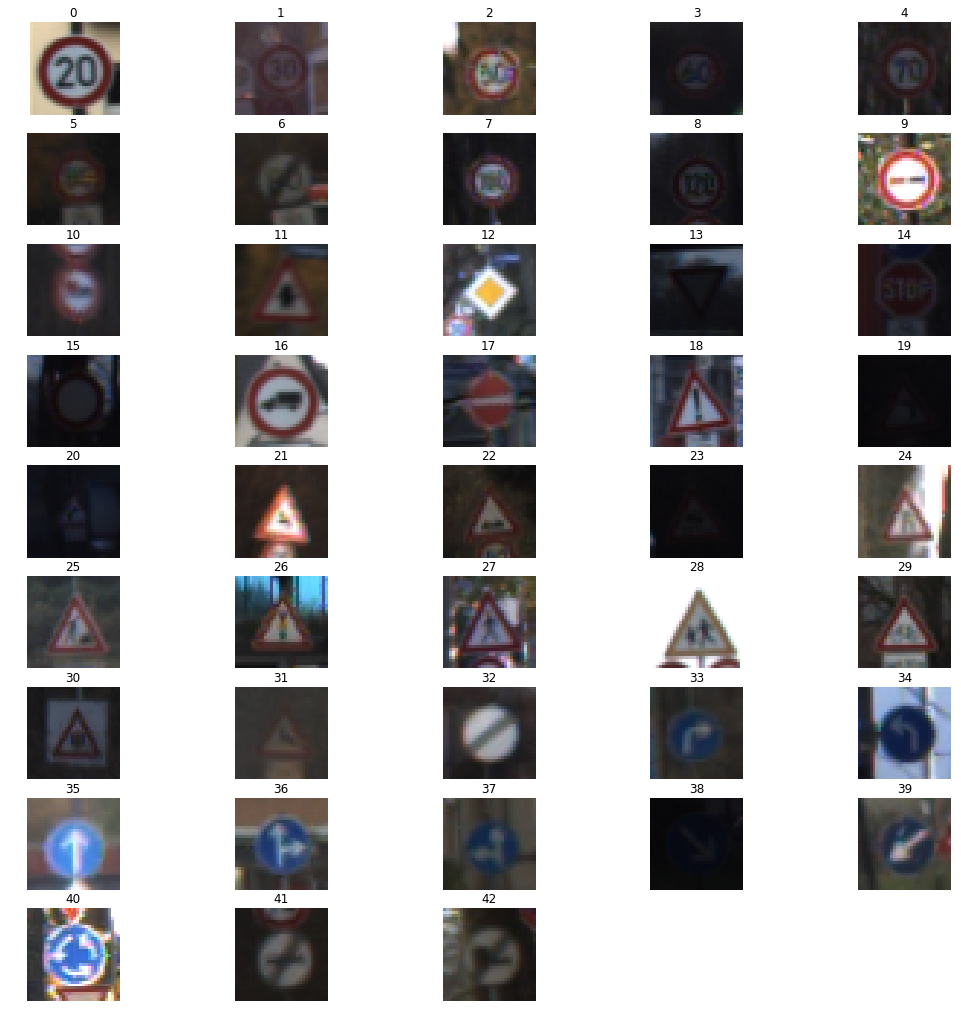

In [5]:
# Show the 43 classes of traffic signs

plt.figure(figsize= (18, 18))
for i in range(0, n_classes):
    plt.subplot(9, 5, i + 1) # set the rows and columns to show the plots
    X_selected = X_train[y_train == i]
    plt.imshow(X_selected[0,]) # show the first instance of each label
    plt.title(i)
    plt.axis("off")
plt.show()

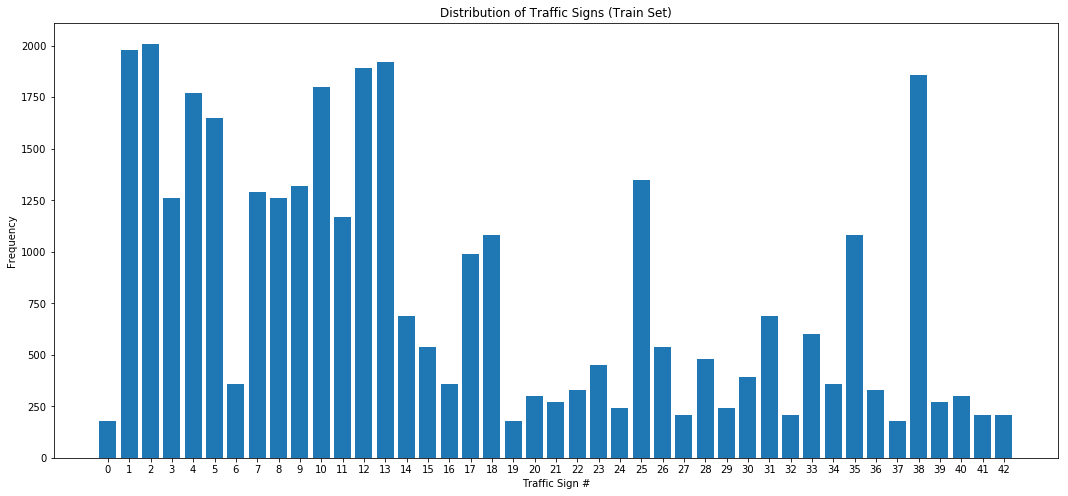

In [6]:
# Plot the histogram of traffic sign counts

unique_val, unique_count = np.unique(y_train, return_counts = True)

plt.figure(figsize=(18, 8))
plt.bar(unique_val, unique_count)
plt.title("Distribution of Traffic Signs (Train Set)")
plt.xlabel("Traffic Sign #")
plt.ylabel("Frequency")
plt.xticks(np.arange(min(y_train), max(y_train) + 1, 1))
plt.show()

### Identify classes that have relatively small data

In [7]:
### Classes with less than (low_count_limit) images
low_count_limit = 750
unique_classes, freq_classes = np.unique(y_train, return_counts = True)
unique = dict(zip(unique_val, unique_count))
low_unique = {k: v for k, v in unique.items() if v < low_count_limit}
#low_unique.keys()
low_class_list = sorted(list(low_unique.keys()))
print(low_class_list)
print("Number of classes below the limit:", len(low_class_list))

[0, 6, 14, 15, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42]
Number of classes below the limit: 26


## Step 2: Data Augmentation

In [8]:
from skimage.transform import rotate
from random import randint

In [9]:
%%time

# augment data to have at least (low_count_limit) images for all classes
for low_class in low_class_list:
    print(low_class, ": ", end = "")
    count_low_class = low_unique[low_class]
    class_index_list = list(np.where(y_train == low_class))
    for i in range(low_count_limit - count_low_class):
        rand_angle = randint(-15, 15)
        new_img = X_train[class_index_list[0][i % count_low_class]]
        new_img = rotate(new_img, rand_angle, mode = "edge")
        X_train = np.concatenate((X_train, [new_img]))
        y_train = np.concatenate((y_train, [low_class]))
        if i == (low_count_limit - count_low_class - 1):
            print("|") # print if done
        elif i == 0:
            pass
        elif (i/(low_count_limit - count_low_class)*100) % 10 == 0: #print progress bar for every 10% complete
            print("#", end = "")
    print()
print("Number of new images added =", len(X_train) - n_train)  
print("Number of total images =", len(X_train))

0 : #########|

6 : #########|

14 : #########|

15 : #########|

16 : #########|

19 : #########|

20 : #########|

21 : #########|

22 : #########|

23 : #########|

24 : #########|

26 : #########|

27 : #########|

28 : #########|

29 : #########|

30 : #########|

31 : #########|

32 : #########|

33 : |

34 : #########|

36 : #########|

37 : #########|

39 : #########|

40 : #########|

41 : #########|

42 : #########|

Number of new images added = 10381
Number of total images = 45180
Wall time: 1h 26min 3s


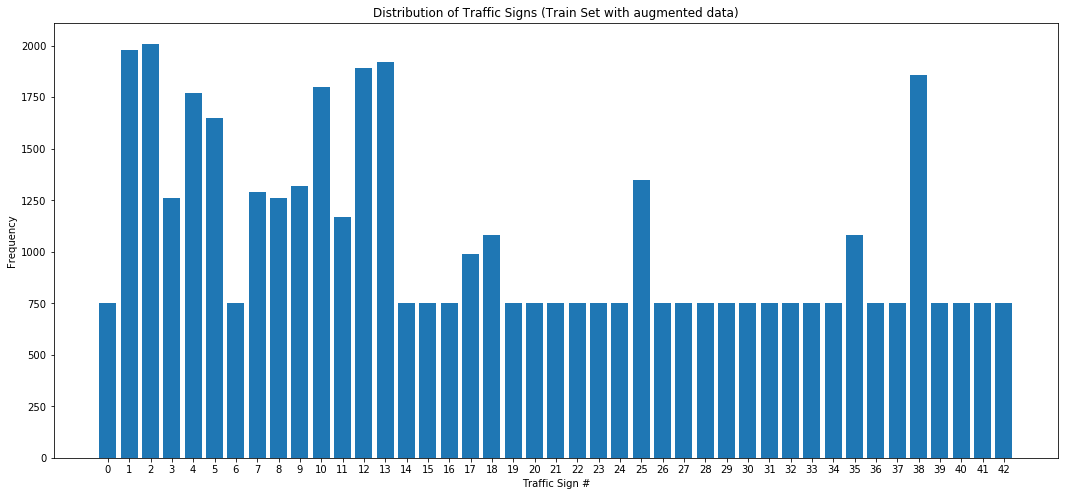

In [10]:
# Plot the histogram of traffic sign counts with augmented data added

unique_val, unique_count = np.unique(y_train, return_counts = True)

plt.figure(figsize=(18, 8))
plt.bar(unique_val, unique_count)
plt.title("Distribution of Traffic Signs (Train Set with augmented data)")
plt.xlabel("Traffic Sign #")
plt.ylabel("Frequency")
plt.xticks(np.arange(min(y_train), max(y_train) + 1, 1))
plt.show()

----

## Step 3: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

In [11]:
import cv2
# function to grayscale image
def grayscale(img):
    img = np.array(img, dtype = np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_expanded = img[:, :, np.newaxis]
    return img_expanded

In [12]:
### Shuffle the training data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [13]:
# function to run all pre-processing
def pre_process(img):
    if grayscale_img:
        img = grayscale(img)
    if normalize_img:
        img = (img - [128]) / 128
    return img

In [14]:
# set pre-processing options
grayscale_img = True
normalize_img = True

# apply pre-processing
X_train = np.array([pre_process(image) for image in X_train])
X_valid = np.array([pre_process(image) for image in X_valid])
X_test = np.array([pre_process(image) for image in X_test])

### Setup Tensorflow

In [21]:
import tensorflow as tf

EPOCHS = 80
BATCH_SIZE = 256
dropout = 0.5

### Model Architecture

In [22]:
### LeNet-5 Architecture
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Layer 3: Convolutional. Input 10x10x16. Output = 6x6x64.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Dropout
    conv3 = tf.nn.dropout(conv3, keep_prob)

    # Pooling. Input = 6x6x64. Output = 3x3x64.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 3x3x64. Output = 576.
    fc0   = flatten(conv3)

    # Layer 4: Fully Connected. Input = 576. Output = 240.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(576, 240), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(240))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1d = tf.nn.dropout(fc1, keep_prob)

    # Layer 5: Fully Connected. Input = 240. Output = 168.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 168), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(168))
    fc2    = tf.matmul(fc1d, fc2_W) + fc2_b

    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2d = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 6: Fully Connected. Input = 168. Output = 84.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(168, 84), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(84))
    fc3    = tf.matmul(fc2d, fc3_W) + fc3_b

    # Activation.
    fc3    = tf.nn.relu(fc3)
    
    # Dropout
    fc3d = tf.nn.dropout(fc3, keep_prob)

    # Layer 7: Fully Connected. Input = 84. Output = 43.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc3d, fc4_W) + fc4_b

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Features and Labels

In [23]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1)) # placeholder for a batch of input images
y = tf.placeholder(tf.int32, (None)) # placeholder for a batch of output labels
keep_prob = tf.placeholder(tf.float32) # placeholder for dropout
one_hot_y = tf.one_hot(y, 43)

### Training Pipeline

In [24]:
rate = 0.0005

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [25]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y , keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Training Model

In [26]:
%%time
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train) # shuffle training set before each epcoh
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        
        # code to show loss plot
        train_loss = sess.run(loss_operation, feed_dict={x: X_train, y: y_train, keep_prob: 1.})
        valid_loss = sess.run(loss_operation, feed_dict={x: X_valid, y: y_valid, keep_prob: 1.})
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        
        # code to show accuracy plot
        training_accuracy = evaluate(X_train, y_train)
        train_acc_list.append(training_accuracy)
        validation_accuracy = evaluate(X_valid, y_valid) # measure the loss and accuracy of the validation set after each epoch
        valid_acc_list.append(validation_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    print()
    print("Epoch:", EPOCHS, "Batch:", BATCH_SIZE, "Dropout:", dropout, "Rate:", rate)

    # show loss plot
    plt.plot(train_loss_list, label="training")
    plt.plot(valid_loss_list, label="validation")
    plt.legend()
    plt.title("loss")
    plt.show()

    # show accuracy plot
    plt.plot(train_acc_list, label="training")
    plt.plot(valid_acc_list, label="validation")
    plt.legend()
    plt.title("accuracy")
    plt.show()
    
    saver.save(sess, './lenet') # save the model after training
    print("Model saved")

Training...



ResourceExhaustedError: OOM when allocating tensor with shape[45180,6,28,28]
	 [[Node: Conv2D_3 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_3_0/_27, Variable_14/read)]]
	 [[Node: Mean_2/_31 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_199_Mean_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Conv2D_3', defined at:
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-425c167936bc>", line 3, in <module>
    logits = LeNet(x)
  File "<ipython-input-22-9eda4b9118ed>", line 12, in LeNet
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Tom\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[45180,6,28,28]
	 [[Node: Conv2D_3 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_3_0/_27, Variable_14/read)]]
	 [[Node: Mean_2/_31 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_199_Mean_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


### Testing Model *(To be run after more tuning)*

In [ ]:
"""
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
"""

---

## Step 4: Test a Model on New Images *(In progress)*

Predicting the traffic sign type of German traffic signs downloaded from the web

### Load and Output the Images

### Predict the Sign Type for Each Image

### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

---

## Step 5: Visualize the Neural Network's State with Test Images *(In progress)*
